# CNN Class Exercise

by Maxwell Ernst 03/07/2023

## Exercise Description:
Choose an image classification problem that is well-suited to be solved using transfer learning. Choose a suitable pretrained model, re-use the weights of the convolutional layers, and train the dense layers using a series of input images of your own choice. 

Hand in your Jupyter notebook which also functions as a research report. You describe the context of the problem at hand, the methods, the results, and your conclusion. To show progress of training, you should create plots of accuracy and loss versus epoch number. For evaluation, you should construct a confusion matrix and discuss your findings. In addition, you can show some example test images that are classified right and some that are classified wrong. This gives an idea of what your network is capable of (in addition to your confusion matrix and other evaluation metrics).

https://www.tensorflow.org/tutorials/images/transfer_learning

# Libraries

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Data

The data set used contains thousands of images of cats and dogs. 

In [10]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [11]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


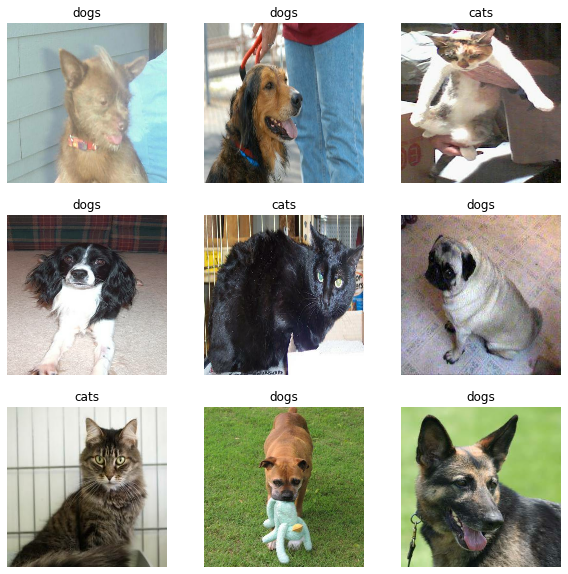

In [12]:
# Showing first 9 images
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Data handling

Creating a test data set for the model

In [13]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


## Using data Augmentation

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Since the data set is not the largest, it is a good idea to introduce some artificial noise to the data set.By applying random transformations to the data set. This helps expose the model to different ascpects of the training data.

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Lets see the results of the asugmentation on one image.

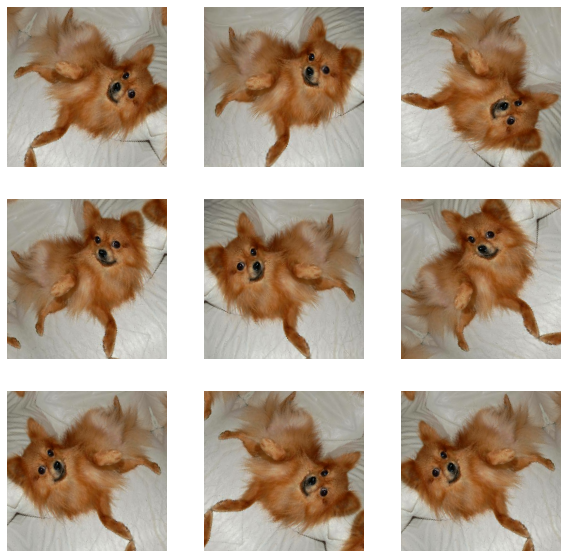

In [18]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

As you can see the image of the dog is flipped horizontally and vertically in the data set.

## Rescaling images

The base model can only yake values between -1,1 therefore we need to convert the value of the pixels from 255 to between -1 and 1.

In [19]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [20]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Creating the base model that will be pre-trained. 

The model chosen is the MobileNetV2 model developed by google. To instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet for feature extraction, you can specify the include_top=False argument. This loads the network without the classification layers at the top, which is perfect for extracting features.

In [21]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 1s 0us/step


The feature extractor converts the images from 160x160x3 to 5x5x1280 block of features.

In [22]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature Extraction

Freezing the convlutional base before compiling and training the model to prevent the weights from being updated.

In [23]:
base_model.trainable = False

In [24]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Adding a classification head.

using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image.

In [26]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Building the model

with training = False and the BatchNormalization layer is used

In [27]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compiling the model 

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

From the summary above it shows that there are over 2,2 million forzen paramater frozen in the MobileNetV2 model. 1,281 are in the dense layer.

In [30]:
len(model.trainable_variables)

2

# Training the model 

Training for 10 Epochs.

In [31]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 17s 453ms/step - loss: 0.6936 - accuracy: 0.5644


In [32]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69
initial accuracy: 0.56


In [33]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 54s 776ms/step - loss: 0.6564 - accuracy: 0.6105 - val_loss: 0.4787 - val_accuracy: 0.7079
Epoch 2/10
63/63 [==============================] - 48s 759ms/step - loss: 0.4846 - accuracy: 0.7255 - val_loss: 0.3497 - val_accuracy: 0.8329
Epoch 3/10
63/63 [==============================] - 50s 786ms/step - loss: 0.3894 - accuracy: 0.8060 - val_loss: 0.2728 - val_accuracy: 0.8886
Epoch 4/10
63/63 [==============================] - 46s 725ms/step - loss: 0.3258 - accuracy: 0.8485 - val_loss: 0.2252 - val_accuracy: 0.9134
Epoch 5/10
63/63 [==============================] - 47s 740ms/step - loss: 0.2888 - accuracy: 0.8715 - val_loss: 0.1921 - val_accuracy: 0.9282
Epoch 6/10
63/63 [==============================] - 47s 739ms/step - loss: 0.2565 - accuracy: 0.8930 - val_loss: 0.1689 - val_accuracy: 0.9381
Epoch 7/10
63/63 [==============================] - 48s 757ms/step - loss: 0.2434 - accuracy: 0.8975 - val_loss: 0.1533 - val_accuracy: 0.9356

### Plotting Learning Curve

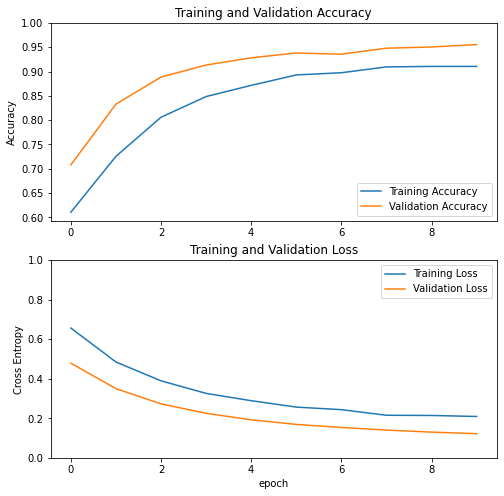

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

In the feature selection we are only training a few layers on top of the MobilveV2 base model. The weights are not updated during the training process. 

To train or fine tune the weights of the top layers of the pre-trained model alonsgide the classifier that was added can increase the performance of the model.

## Un-freeze the top layers of the model. 

In [35]:
base_model.trainable = True

In [36]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


# Continuing the training

In [37]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 49s 755ms/step - loss: 0.1883 - accuracy: 0.9205 - val_loss: 0.1161 - val_accuracy: 0.9567
Epoch 11/20
63/63 [==============================] - 45s 709ms/step - loss: 0.1863 - accuracy: 0.9250 - val_loss: 0.1110 - val_accuracy: 0.9567
Epoch 12/20
63/63 [==============================] - 62s 983ms/step - loss: 0.1777 - accuracy: 0.9270 - val_loss: 0.1058 - val_accuracy: 0.9604
Epoch 13/20
63/63 [==============================] - 69s 1s/step - loss: 0.1672 - accuracy: 0.9265 - val_loss: 0.1016 - val_accuracy: 0.9691
Epoch 14/20
63/63 [==============================] - 72s 1s/step - loss: 0.1793 - accuracy: 0.9225 - val_loss: 0.0958 - val_accuracy: 0.9678
Epoch 15/20
63/63 [==============================] - 76s 1s/step - loss: 0.1674 - accuracy: 0.9350 - val_loss: 0.0907 - val_accuracy: 0.9703
Epoch 16/20
63/63 [==============================] - 597130s 9631s/step - loss: 0.1576 - accuracy: 0.9325 - val_loss: 0.0925 - val_accuracy: 0.96